In [1]:
from numpy import reshape
import seaborn as sns
import pandas as pd  
import torch
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import soundfile as sf
import numpy as np
from IPython.display import display, Audio
import librosa
def ms2samples(time, rate):
    return int((time/1000)*rate)

def samples2ms(sample,rate):
    return int((sample/rate)*1000)
    
def graph_n_play(y,sr):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(y, sr=sr)
    plt.show()
    ipd.display(ipd.Audio(y,rate = sr))
def linear_n_play(audio_path):
    # y, sr = sf.read(audio_path)
    y, sr = librosa.load(audio_path)
    fig, ax = plt.subplots()
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                                   sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram')
    ax.label_outer()
    display(Audio(y,rate=sr))
    plt.show()

/home/phucdt/anaconda3/envs/bio/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


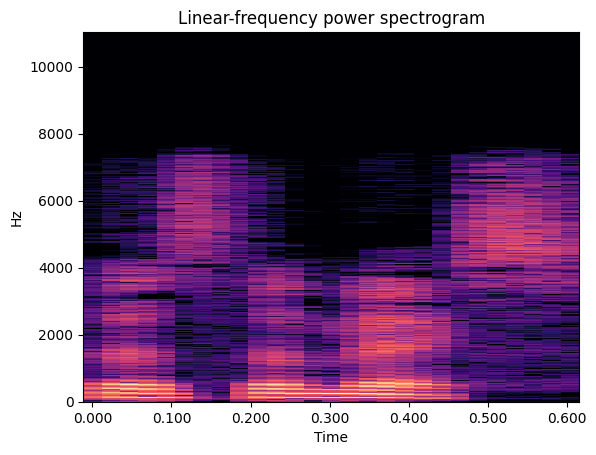

In [31]:
# linear_n_play("/dataa/Dataset/ASVspoof_trimmed/ASVspoof2021_DF_eval/flac/DF_E_2308589.flac")
linear_n_play("/dataa/Dataset/ASVspoof/LA/ASVspoof2021_DF_eval/flac/DF_E_4468677.flac")

In [2]:

mypath = "/datac/ASVspoof2019_eval/lpc_small_64000_trim/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [3]:
df = pd.DataFrame()
# feat.columns = ["utt", "feats"]

for f in tqdm(onlyfiles):
    # print(f)
    feat = np.load(join(mypath, f)).flatten()
    df = df.append({"utt": f.replace(".npy",""), "feats": feat}, ignore_index=True)
    # print(bio_inp)

100%|██████████| 71933/71933 [02:01<00:00, 593.27it/s]


In [5]:
la = pd.read_csv('/dataa/Dataset/ASVspoof/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt', sep=' ')
la.columns = ["sid", "utt", "phy", "attack", "class"]
full = la.join(df.set_index('utt'), on="utt")
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71236 entries, 0 to 71235
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sid     71236 non-null  object
 1   utt     71236 non-null  object
 2   phy     71236 non-null  object
 3   attack  71236 non-null  object
 4   class   71236 non-null  object
 5   feats   71236 non-null  object
dtypes: object(6)
memory usage: 3.3+ MB


In [6]:
X=np.array(full["feats"].to_list())
X.shape

(71236, 315)

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [8]:
# X_embedded = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(X)
z = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(X)

/home/phucdt/anaconda3/envs/bio/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [15]:
y = full["class"].replace("-","bonafide")

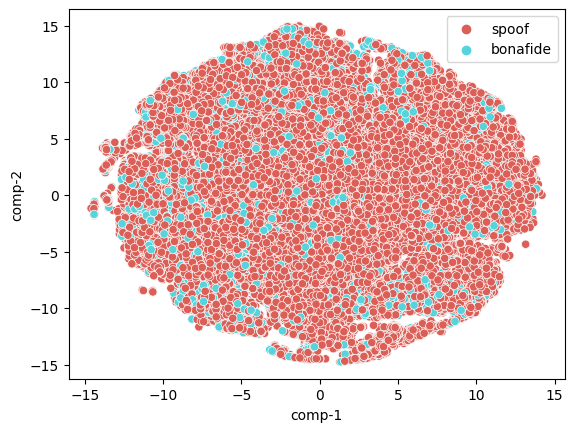

In [17]:
dff = pd.DataFrame()
dff["y"] = y
dff["comp-1"] = z[:,0]
dff["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=dff.y.tolist(),
                palette=sns.color_palette("hls", 2
                                          ),
                data=dff).set(title="") 
plt.savefig('lpc_trim_64000_eval2021',dpi=600)

In [18]:
import torchaudio
import torch
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bundle = torchaudio.pipelines.WAV2VEC2_LARGE
model = bundle.get_model().to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_large_ls960.pth" to /home/phucdt/.cache/torch/hub/checkpoints/wav2vec2_fairseq_large_ls960.pth
100%|██████████| 1.18G/1.18G [03:17<00:00, 6.37MB/s]  


In [19]:
def load_audio(path):
    data, sample_rate = sf.read(path)
    if data.size == 0:
        # logging.error("file {} has zero size".format(path))
        exit(0)
    # Convert to mono and normalize
    if data.ndim > 1:
        data = np.mean(data, axis=1)  # convert to mono
    data = data / np.max(np.abs(data))  # normalize to [-1, 1]
    return data, sample_rate

In [47]:
audio =  "/dataa/Dataset/ASVspoof_trimmed/ASVspoof2021_DF_eval/flac/DF_E_2179212.flac"
data, sr = load_audio(audio)
input = torch.unsqueeze(torch.from_numpy(data),0).to(device=device, dtype=torch.float)
input
out = model(input)

In [52]:
out[0][-1][-1].detach().cpu().numpy()

array([ 1.4066896 , -0.2765486 ,  0.07234906, ..., -0.15212831,
        0.19858585,  0.02354747], dtype=float32)